# Starbucks Promotional Offers Data Analysis Project

In [1]:
# Import Python data modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import other functions
from ast import literal_eval
from sqlalchemy import create_engine
from scipy.stats import linregress

## Importing & Inspecting

In [2]:
# Load the data into pd.DataFrame objects using pandas
customers = pd.read_csv('data/customers.csv')
offers = pd.read_csv('data/offers.csv')
events = pd.read_csv('data/events.csv')

In [3]:
# Make sure the offers table loaded in correctly by checking the head
offers.head(3)

,offer_id,offer_type,difficulty,reward,duration,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']"
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"['web', 'email', 'mobile']"


The `offers` data has loaded in correctly. The `channels` column has values in the form of lists, which pandas does not work well with. This will need to be cleaned.

In [4]:
# Make sure the customers table loaded in correctly by checking the head
customers.head(3)

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,20170715,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,118,NaN


The `customers` table has loaded in correctly. The `became_member_on` column will need to be changed into a datetime data type.

In [5]:
# Make sure the events table loaded in correctly by checking the head
events.head(3)

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


The `events` table has loaded in correctly. The `value` column has values in the form of dictionaries, which pandas does not work well with. This will need to be cleaned. The `time` column can be used to engineer more informative columns.

## Cleaning & Wrangling
For each table, investigate and clean the following: 
- Data types will need to be converted
- Bit-sizes can be decreased
- Possible outliers may exist in numeric columns
- Missing data may exist
- Duplicates may exists
- Inconsistent text and typos may exist in categorical columns 

### Offers Table
The `channels` column in the `offers` table is in the form of lists. Create dummy variables for the individual channels to make the column easier to use and investigate.

In [6]:
# Turn channels column into list type using the imported literal_eval function
offers['channels'] = offers['channels'].apply(literal_eval)

# Create channels dummies for each channel
for channel in ['web', 'email', 'mobile', 'social']:
    offers[channel] = offers['channels'].apply(lambda x: 1 if channel in x else 0).astype('int8')

# Drop the original columns list
offers = offers.drop('channels', axis=1)

In [7]:
# Check the data types, bit-sizes, and memory usage of the offers table
offers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   offer_id    10 non-null     object
 1   offer_type  10 non-null     object
 2   difficulty  10 non-null     int64 
 3   reward      10 non-null     int64 
 4   duration    10 non-null     int64 
 5   web         10 non-null     int8  
 6   email       10 non-null     int8  
 7   mobile      10 non-null     int8  
 8   social      10 non-null     int8  
dtypes: int64(3), int8(4), object(2)
memory usage: 1.7 KB


In [8]:
# Check the summary statistics for the numeric columns to see if bit-sizes can be reduced and identify possible outliers
offers.describe().round()

,difficulty,reward,duration,web,email,mobile,social
count,10.0,10.0,10.0,10.0,10.0,10.0,10.0
mean,8.0,4.0,6.0,1.0,1.0,1.0,1.0
std,6.0,4.0,2.0,0.0,0.0,0.0,1.0
min,0.0,0.0,3.0,0.0,1.0,0.0,0.0
25%,5.0,2.0,5.0,1.0,1.0,1.0,0.0
50%,8.0,4.0,7.0,1.0,1.0,1.0,1.0
75%,10.0,5.0,7.0,1.0,1.0,1.0,1.0
max,20.0,10.0,10.0,1.0,1.0,1.0,1.0


- The `difficulty`, `reward`, and `duration` columns take integer values between 0 and 20. I will reduce the bit-sizes for those columns to the minimum bit-size to reduce memory usage and optimise efficiency.
- Change the `offer_type` column to category. It is a categorical column because it says in the data dictionary.
- There are no outliers or unreasonable values.

In [9]:
# Reduce the bit-sizes of the numeric columns
offers = offers.astype({
    'difficulty': 'int8',
    'reward': 'int8',
    'duration': 'int8',
    'offer_type': 'category' #Convert offer_type into a category data type
})

In [10]:
# Check to see if the changes occured
offers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   offer_id    10 non-null     object  
 1   offer_type  10 non-null     category
 2   difficulty  10 non-null     int8    
 3   reward      10 non-null     int8    
 4   duration    10 non-null     int8    
 5   web         10 non-null     int8    
 6   email       10 non-null     int8    
 7   mobile      10 non-null     int8    
 8   social      10 non-null     int8    
dtypes: category(1), int8(7), object(1)
memory usage: 1.3 KB


In [11]:
# Check for any missing data
offers.isna().sum()

offer_id      0
offer_type    0
difficulty    0
reward        0
duration      0
web           0
email         0
mobile        0
social        0
dtype: int64

In [12]:
# Check for any inconsistent text or typos in category columns
offers['offer_type'].unique()

['bogo', 'informational', 'discount']
Categories (3, object): ['bogo', 'discount', 'informational']

In [13]:
# Check for any duplicate rows
offers.duplicated().sum()

0

### Customers Table

In [14]:
# Check the data types, size, and memory usage of the customers data frame
customers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       17000 non-null  object 
 1   became_member_on  17000 non-null  int64  
 2   gender            14825 non-null  object 
 3   age               17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.5 MB


In [15]:
# Check the summary statistics for the numeric columns to see if we can reduce bit-sizes and identify possible outliers
customers.describe().round()

,became_member_on,age,income
count,17000.0,17000.0,14825.0
mean,20167034.0,63.0,65405.0
std,11677.0,27.0,21598.0
min,20130729.0,18.0,30000.0
25%,20160526.0,45.0,49000.0
50%,20170802.0,58.0,64000.0
75%,20171230.0,73.0,80000.0
max,20180726.0,118.0,120000.0


- The `age` column take integer values between 0 and 118 and `income` takes float values between 30000 and 120000. Reduce the bit-sizes for those columns.
- Change the `gender` column to category. It is a categorical column because it says in the data dictionary.
- Change the `became_member_on` to datetime data type.
- A possible outlier could be 118 in the `age` column. investigate this more.

In [16]:
# Convert the data types of the column in the wrong data type and reduce bit-sizes of numeric columns to save space
customers = customers.astype({
    'gender': 'category',
    'age': 'int16',
    'income': 'float32'
})

# Convert the became_member_on column to datetime dtype
customers['became_member_on'] = pd.to_datetime(customers['became_member_on'], format='%Y%m%d')

In [17]:
# Check to see if the changes occured
customers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       17000 non-null  object        
 1   became_member_on  17000 non-null  datetime64[ns]
 2   gender            14825 non-null  category      
 3   age               17000 non-null  int16         
 4   income            14825 non-null  float32       
dtypes: category(1), datetime64[ns](1), float32(1), int16(1), object(1)
memory usage: 1.6 MB


In [18]:
# Check for any missing data
customers.isna().sum()

customer_id            0
became_member_on       0
gender              2175
age                    0
income              2175
dtype: int64

In [19]:
# Investigate the rows that have missing values
customers_nan_rows = customers[customers.isna().any(axis=1)]
customers_nan_rows.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN
6,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,118,NaN
7,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,118,NaN


In [20]:
# Check to see how many rows have values missing
len(customers_nan_rows)

2175

In [21]:
# Check the ages of all the missing values
customers_nan_rows['age'].unique()

array([118], dtype=int16)

In [22]:
# Check how many 118 values there are in the age column
(customers['age'] == 118).sum()

2175

In [23]:
# Check the % of missing data
(len(customers_nan_rows) / len(customers)) * 100

12.794117647058822

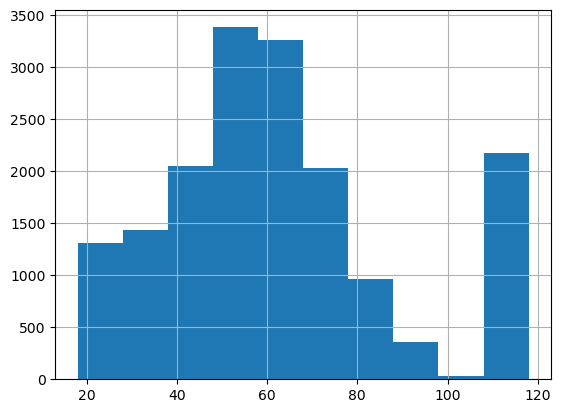

In [24]:
# Check the distribution of the age column
customers['age'].hist();

In `customers`, there are 2175 missing values each for both the `gender` and `income` columns. These missing values all occur in the same rows, meaning that there are 2175 rows that miss both the `gender` and `income` values. In addition, each one of these rows has `118` for its value for `age`, indicating that this is a placeholder for missing information. Moreover, it is skewing the distribution for the `age` column, so we will change these values to `np.NaN` values. Even though the rows with missing values make up 12.8% of our data, I will leave all the missing values as is for now so we do not lose any info when we join the tables later.

In [25]:
# Replace the values of 118 in the age column with np.NaN values
customers['age'] = customers['age'].replace({118: np.NaN})

In [26]:
# Check for dupilcate rows
customers.duplicated().sum()

0

### Events Table
The `events` table has a column called `value` that is in the form of dictionaries. Seperate the keys and values into seperate columns.

In [27]:
# Turn channels column into dict type
events['value'] = events['value'].apply(literal_eval)

# Create a series that holds the dictionary keys as a list
value_keys = events['value'].apply(lambda dict: list(dict.keys()))

# Create a series that holds the dictionary values as a list
value_values = events['value'].apply(lambda dict: list(dict.values()))

In [28]:
# Check to see what values are in the dictionaries by checking the different possible keys.
value_keys.value_counts()

value
[amount]              138953
[offer id]            134002
[offer_id, reward]     33579
Name: count, dtype: int64

It looks like the `value` column has three different types of keys, which are `amount`, `offer_id`/`offer id`, and `reward`. Upon further investigation, the `value` values that have `amount` as their key are `transaction` events, the `value` values that just have `offer_id`/`offer id` as their key are `offer received` and `offer viewed` events, and `value` values that have both `offer_id` and `reward` as their keys are `offer completed` events. I will now create columns for these individual keys and corresponding values. However, for reward, I will just create a column called `reward` and fill it with the value or `NaN`.

In [29]:
# Create a column that hold the value key (either amount or offer id/offer_id)
events['value_key'] = value_keys.apply(lambda lst: lst[0])

# Create a column that holds the value value (either the amount or the offer id/offer_id)
events['value'] = value_values.apply(lambda lst: lst[0])

#Create a column that holds the reward value if it exists
events['reward'] = value_values.apply(lambda lst: lst[1] if len(lst) == 2 else np.NaN)

I will now change the `time` column into more informative columns. The time column shows the number of hours passed in the 30 day period. Hence, I will make a column for the day and a column for the hour of that day. I also descovered, for reasons I can not explain, that the hours are rounded to the nearest multiple of six. Luckily, this makes no significant changes to my analysis.

In [30]:
# Turn the time column into two columns that is the day number and hour of that day
events['day'] = events['time'] // 24
events['hour'] = events['time'] % 24

In [31]:
# Check the data types, size, and memory usage of the events table
events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  306534 non-null  object 
 1   event        306534 non-null  object 
 2   value        306534 non-null  object 
 3   time         306534 non-null  int64  
 4   value_key    306534 non-null  object 
 5   reward       33579 non-null   float64
 6   day          306534 non-null  int64  
 7   hour         306534 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 84.6 MB


In [32]:
# Check the summary statistics for the numeric columns to see if we can reduce bit-sizes and identify possible outliers
events.describe().round()

,time,reward,day,hour
count,306534.0,33579.0,306534.0,306534.0
mean,366.0,5.0,15.0,6.0
std,200.0,3.0,8.0,7.0
min,0.0,2.0,0.0,0.0
25%,186.0,2.0,7.0,0.0
50%,408.0,5.0,17.0,6.0
75%,528.0,5.0,22.0,12.0
max,714.0,10.0,29.0,18.0


In [33]:
# Check if the event column is categorical and if there is any inconsistent text or typos 
events['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [34]:
# Check if the value_key column is categorical and if there is any inconsistent text or typos 
events['value_key'].value_counts()

value_key
amount      138953
offer id    134002
offer_id     33579
Name: count, dtype: int64

In [35]:
# Fix the inconsitent text
events['value_key'] = events['value_key'].replace({'offer_id': 'offer id'})

In [36]:
# Check to see if the inconsitent text was fixed
events['value_key'].value_counts()

value_key
offer id    167581
amount      138953
Name: count, dtype: int64

In [37]:
# Convert the data types of the column in the wrong data type and reduce bit-sizes of numeric columns to save space
events = events.astype({
    'event': 'category',
    'value_key': 'category',
    'reward': 'float32',
    'day': 'int8',
    'hour': 'int8'
})

In [38]:
# Check to see if the changes occured
events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   customer_id  306534 non-null  object  
 1   event        306534 non-null  category
 2   value        306534 non-null  object  
 3   time         306534 non-null  int64   
 4   value_key    306534 non-null  category
 5   reward       33579 non-null   float32 
 6   day          306534 non-null  int8    
 7   hour         306534 non-null  int8    
dtypes: category(2), float32(1), int64(1), int8(2), object(2)
memory usage: 45.5 MB


In [39]:
# Check for missing values
events.isna().sum()

customer_id         0
event               0
value               0
time                0
value_key           0
reward         272955
day                 0
hour                0
dtype: int64

These missing values are a reflection of the amount of events in the table that are not `offer completed`. Therefore we want these values to remain missing.

In [40]:
# Check for duplicate rows
events.duplicated().sum()

397

In [41]:
# Investigate the duplicate rows
events_dup_rows = events[events.duplicated()]
events_dup_rows.head()

,customer_id,event,value,time,value_key,reward,day,hour
66123,3dde94fa581145cb9f206624f1a94d5a,offer completed,2906b810c7d4411798c6938adc9daaa5,168,offer id,2.0,7,0
66783,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,168,offer id,10.0,7,0
67614,a7dc060f6fc94ca7bf71fbb188187dca,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,offer id,5.0,7,0
68562,30478a4c1e884a63a822aa87b833ed7a,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,168,offer id,3.0,7,0
69218,84fb57a7fe8045a8bf6236738ee73a0f,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,168,offer id,10.0,7,0


In [42]:
# Investigate the event types of the duplicate rows
events_dup_rows['event'].unique()

['offer completed']
Categories (4, object): ['offer completed', 'offer received', 'offer viewed', 'transaction']

In [43]:
# Investigate the offer types of duplicate rows
events_dup_rows.merge(offers, how='inner', left_on='value', right_on='offer_id')['offer_type'].unique()

['discount', 'bogo']
Categories (3, object): ['bogo', 'discount', 'informational']

The only consitency with all the duplicate values in the `events` table is that they are all `offer completed` events. There will be no analysis on duplicate rows in our analysis. So I will delete them.

In [44]:
# Drop the duplicates in the events table
events = events.drop_duplicates()

In [45]:
# Divide the value column into two columns based on the value of value_key and drop the old columns
events['amount'] = np.where(events['value_key'] == 'amount', events['value'], np.NaN)
events['offer_id'] = np.where(events['value_key'] == 'offer id', events['value'], np.NaN)
events = events.drop(['value', 'value_key'], axis=1)

# Reorder the columns into a more intuitive order
events = events[['event', 'time', 'day', 'hour', 'customer_id', 'offer_id', 'amount', 'reward']]

In [46]:
events.head()

,event,time,day,hour,customer_id,offer_id,amount,reward
0,offer received,0,0,0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,0,0,0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,0,0,0,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,0,0,0,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,0,0,0,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [47]:
# Create transactions table that will be merged
transactions = events[events['event'] == 'transactions'].drop(['offer_id', 'reward', 'event'], axis=1)

# Join transactions and offer completed events
events = (events[events['event'] != 'transaction']                                                 # Filter out the transactions events
                     .drop('amount', axis=1)
                     .merge(transactions, how='left', on=['time', 'day', 'hour', 'customer_id']))  # Join the transactions table

Note that this gets rid of transactions that did not redeem an offer in the events table. Also note that there are some transactions where the customer gets the reward without reaching the difficulty. This is likely because the transaction amount has the reward already taken out.

Since the `events` table has has four distinct events. It seems benificial to break up the `events` table into the four distinct tables and clean the now seperate tables accordingly

In [48]:
# Divide the events table into four seperate tables
offers_received = events[events['event'] == 'offer received'][['customer_id', 'offer_id', 'time', 'day', 'hour']]
offers_viewed = events[events['event'] == 'offer viewed'][['customer_id', 'offer_id', 'time', 'day', 'hour']]
transactions = events[events['event'] == 'transactions'][['customer_id', 'offer_id', 'time', 'day', 'hour']]

In [49]:
offers_completed = events[events['event'] == 'offer completed'][['customer_id', 'offer_id', 'time', 'reward', 'day', 'hour', 'amount']]

# Engineer a new column that has the amount before discount
offers_completed['due_amount'] = offers_completed['reward'] + offers_completed['amount']

# Rename the column that has the price after discount to a more intuitive name
offers_completed = offers_completed.rename({'amount': 'discounted_amount'}, axis=1)

## Exporting to MySQL for Exploratory Data Analysis
Since SQL is better and joining and querying tables than Python, I will export all the cleaned tables to MySQL for some exploratory data analysis.

In [50]:
# Create a connection to the MySQL database
user = 'root'
hidden = 'Basketba11isgood' 
host = 'localhost'
port = '3306'
database = 'starbucks_promotions_db'

connection = create_engine(f'mysql+mysqlconnector://{user}:{hidden}@{host}:{port}/{database}')

In [51]:
# Export the tables to MySQL
data = [offers, customers, offers_received, offers_viewed, transactions]
table_names = ['offers', 'customers', 'offers_received', 'offers_viewed', 'transactions']

for i, table in enumerate(data):
   table.to_sql(table_names[i], con=connection, if_exists='replace', index=False)

## Python Exploratory Data Analysis
Check to see how offers performed throughout the 30 day period

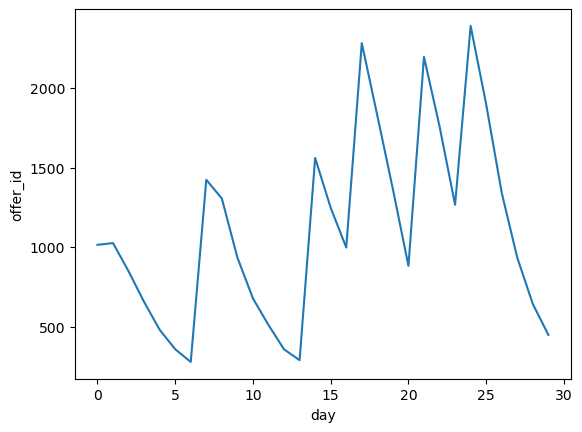

In [52]:
# Create the table to plot the offers completed throughout the 30 day period
num_completed_by_day = offers_completed.groupby('day')['offer_id'].count()  
fig, ax = plt.subplots()
sns.lineplot(num_completed_by_day, ax=ax)
plt.show()

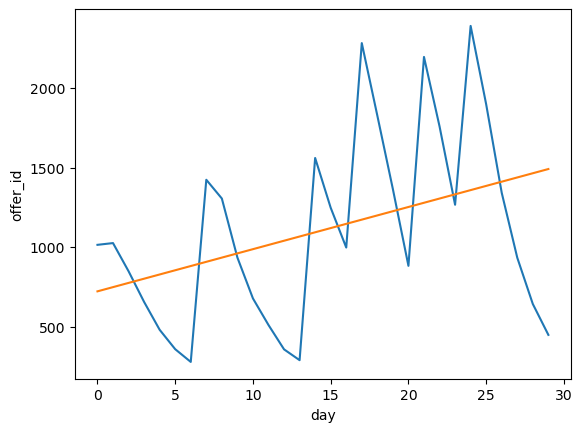

(0.03661413822039195, 26.513459399332593, 0.14681750867457152)

<Figure size 640x480 with 0 Axes>

In [53]:
# Plot a trend line to see the general upward increase
x = num_completed_by_day.index
y = num_completed_by_day
fig, ax = plt.subplots()
sns.lineplot(num_completed_by_day, ax=ax)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), label='Trend line')
plt.show()
plt.clf()
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Check the p_value, slope, and r_value^2 of the trend line
p_value, slope, r_value ** 2

Although highly volitile, offers were completed at an increasing statistically significant (p = 0.04) rate of 26.5 more completions per day throughout the 30 day period

In [54]:
# Check to see what days offers are released
offers_received['day'].value_counts().sort_index()

day
0     12650
7     12669
14    12711
17    12778
21    12704
24    12765
Name: count, dtype: int64

Offers were only sent on the above days

In [55]:
# Find out the average amount of times an offer was sent out per release day per offer
(offers_received.merge(offers[['offer_id', 'offer_type']], how='inner', on='offer_id')
                .pivot_table(index='day', columns='offer_id', values='hour', aggfunc='count', observed=False)
                .mean()
                .mean()
                .round(1)
)

1271.3

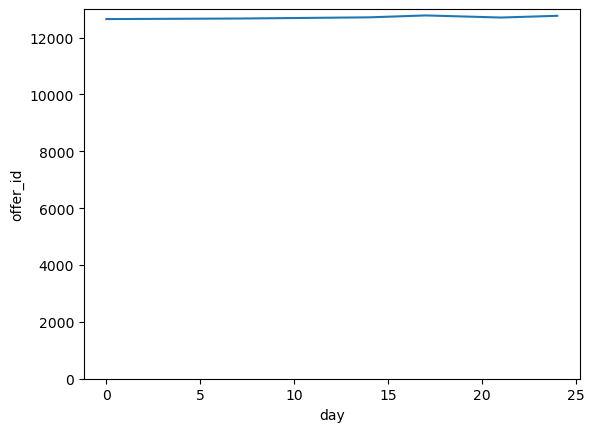

In [56]:
# Plot a line graph of offers received throughout the 30 day period to see if there are any changes
fig, ax = plt.subplots()
sns.lineplot(offers_received.groupby('day')['offer_id'].count(), ax=ax)
ax.set_ylim(0, 13000)
plt.show()

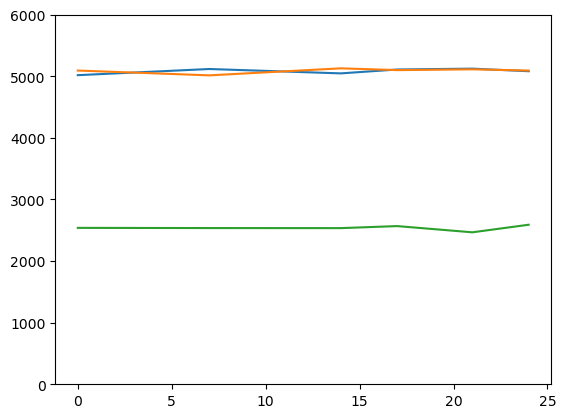

<Figure size 640x480 with 0 Axes>

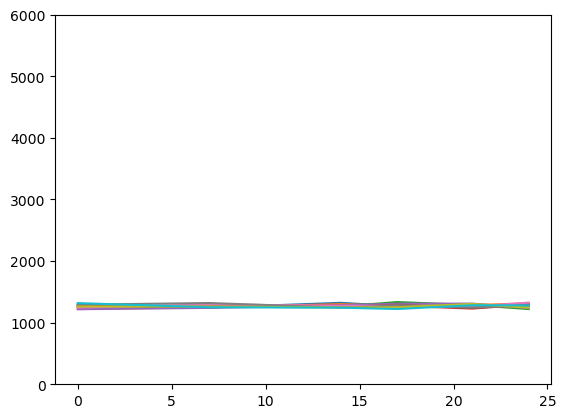

<Figure size 640x480 with 0 Axes>

In [57]:
# Create the DataFrame that will be used to plot the offers recieved by offer type
offers_received_plot = (offers_received.merge(offers[['offer_id', 'offer_type']], how='inner', on='offer_id')
                                       .pivot_table(index='day', columns='offer_type', values='hour', aggfunc='count', observed=False))

# Create the DataFrame that will be used to plot the offers recieved by individual offer
offerID_received_plot = offers_received.pivot_table(index='day', columns='offer_id', values='hour', aggfunc='count', observed=False)

# Plot offers recieved by offer type and offer id respectively to see if there are any changes in which offers were sent out
for offers_plot in [offers_received_plot, offerID_received_plot]:
    fig, ax = plt.subplots()
    ax.plot(offers_plot)
    #ax.set_title()
    ax.set_ylim(0, 6000)
    plt.show()
    plt.clf()

The above analysis reveals the following:
- Offers were released on days 0, 7, 14, 17, 21, and 24
- On each of the release days, each offer was sent out 1271 times on average
- The total amount of offers sent out remained consistent throughout the 30 days.
- Each offer was sent out similar amounts of times with little change througjhout the 30 days

In [58]:
# Get the offerid_performance table created in SQL
performance = pd.read_sql('SELECT * FROM offerid_performance', con=connection)

# Check to make sure the table loaded in correctly
performance.head()

,offer_id,num_completed,offer_type,total_discounted_amount,total_due_amount,total_cm_saved_amount,difficulty,reward,duration
0,fafdcd668e3743c1bb461111dcafc2a4,5265,discount,96900.0,107430.0,10530.0,10,2,10
1,2298d6c36e964ae4a3e7e9706d1fb8c2,5112,discount,89848.0,105184.0,15336.0,7,3,7
2,ae264e3637204a6fb9bb56bc8210ddfd,3635,bogo,87110.0,123460.0,36350.0,10,10,7
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,3340,discount,85986.0,102686.0,16700.0,20,5,10
4,f19421c1d4aa40978ebb69ca19b0e20d,4262,bogo,83147.0,104457.0,21310.0,5,5,5


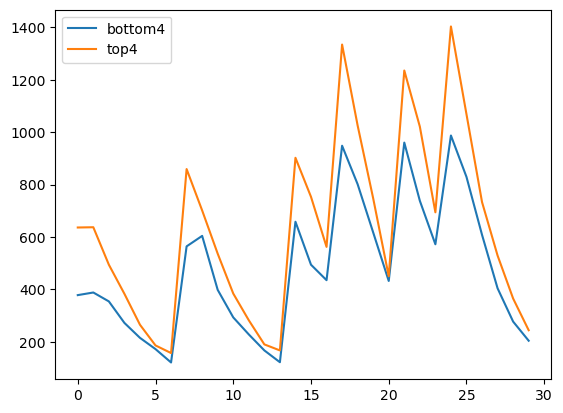

<Figure size 640x480 with 0 Axes>

In [59]:
# Create a column in the offers_completed table that says if an offer was a higher performer of not (top 4/bottom 4) excluding info offers
offers_completed['performance_group'] = np.where(offers_completed['offer_id'].isin(list(performance.sort_values('num_completed', ascending=False)['offer_id'].iloc[:4])), 
                                                 'top4', 
                                                 'bottom4'
                                                )

# Filter out informational offers
performance_offers_completed = offers_completed[offers_completed['offer_id'].isin(list(performance['offer_id']))]

# Create the DataFrame that will be used to plot the offers completed by performance (top 4/bottom 4)
performance_completed_plot = performance_offers_completed.pivot_table(index='day', columns='performance_group', values='hour', aggfunc='count', observed=False)

# Plot the offers completed by performance (top 4/bottom 4)
fig, ax = plt.subplots()
ax.plot(performance_completed_plot)
#ax.set_title()
ax.legend(performance_completed_plot.columns)
plt.show()
plt.clf()

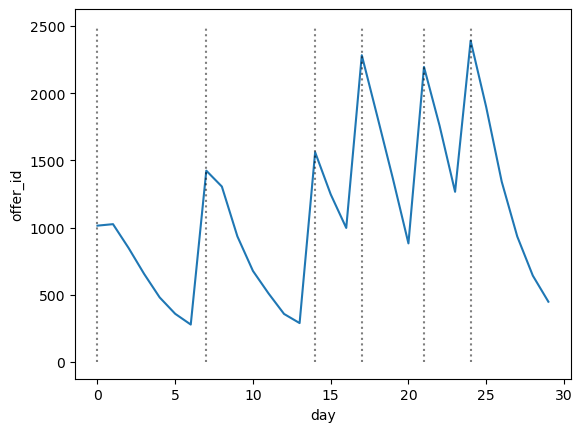

In [60]:
# Check to see if the increase in offers completed is because its on release days  
fig, ax = plt.subplots()
sns.lineplot(num_completed_by_day, ax=ax)
ax.vlines(offers_received_plot.index, 0, 2500, linestyle=':', alpha=0.5, color='black')
plt.show()

This seems to be the most likely cause. I will still inspect other possible causes.

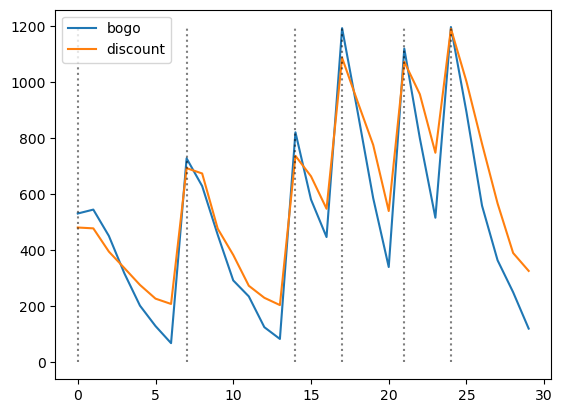

In [61]:
# Create the DataFrame that will be used to plot the offers completed by offer type (bogo/discount)
offers_completed_plot = (offers_completed.merge(offers[['offer_id', 'offer_type']], how='inner', on='offer_id')
                                        .pivot_table(index='day', columns='offer_type', values='hour', aggfunc='count', observed=False)
                                        .drop('informational', axis=1))

# plot the offers completed by offer type (bogo/discount)
fig, ax = plt.subplots()
ax.plot(offers_completed_plot)
ax.legend(offers_completed_plot.columns)
ax.vlines(offers_received_plot.index, 0, 1200, linestyle=':', alpha=0.5, color='black')
plt.show()

In [62]:
# Check the total completed offers by offer
performance.groupby('offer_type')['num_completed'].sum()

offer_type
bogo        15501
discount    17681
Name: num_completed, dtype: int64

In [63]:
# Find out by how much offers completed increased on offer release days compared to the day before
release_day_completed_increase = {}
for release_day in offers_received['day'].unique():
    if release_day == 0:
        release_day_completed_increase[release_day] = num_completed_by_day.loc[0]
    else:
        release_day_completed_increase[release_day] = num_completed_by_day.loc[release_day] - num_completed_by_day.loc[release_day - 1]
release_day_completed_increase

{0: 1014, 7: 1145, 14: 1271, 17: 1285, 21: 1313, 24: 1124}

In [64]:
# Find the average increase
np.mean(list(release_day_completed_increase.values()))

1192.0

Investigate the offers viewed performance

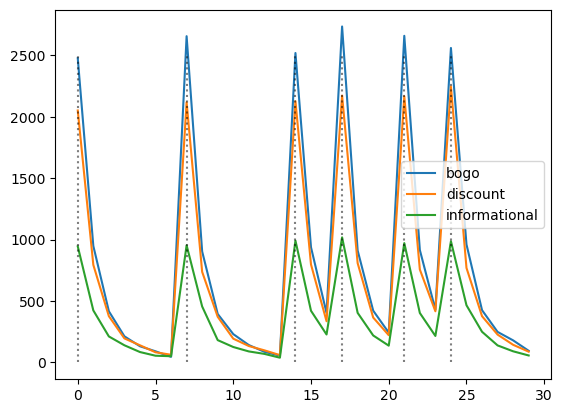

In [65]:
# Create the DataFrame that will be used to plot the offers viewed by individual offer
offers_viewed_plot = (offers_viewed.merge(offers[['offer_id', 'offer_type']], how='inner', on='offer_id')
                                   .pivot_table(index='day', columns='offer_type', values='hour', aggfunc='count', observed=False))

# Plot the offers viewed by individual offer
fig, ax = plt.subplots()
ax.plot(offers_viewed_plot)
ax.legend(offers_viewed_plot.columns)
ax.vlines(offers_received_plot.index, 0, 2500, linestyle=':', alpha=0.5, color='black')
plt.show()

<Axes: xlabel='day', ylabel='count'>

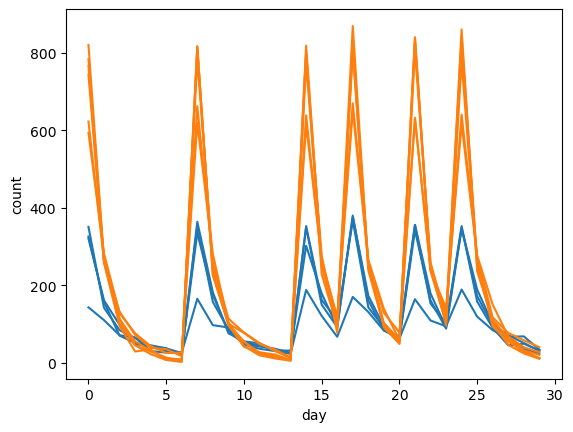

In [66]:
offer_daily_viewed = offers_viewed.groupby(['day', 'offer_id']).size().reset_index(name='count').merge(offers[['offer_id', 'social']], how='inner', on='offer_id')

sns.lineplot(data=offer_daily_viewed, x='day', y='count', hue='social', style='offer_id', dashes=False, legend=False)

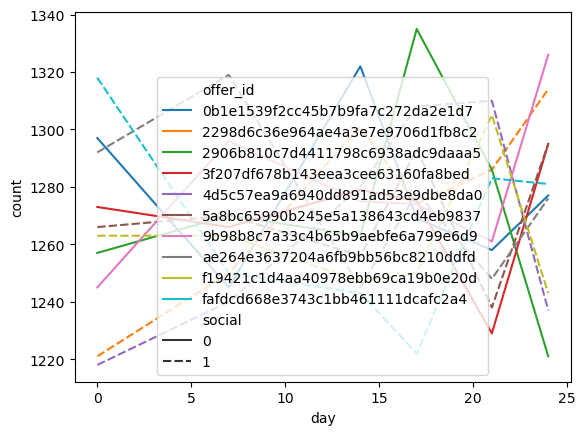

In [67]:
offer_daily_received = offers_received.groupby(['day', 'offer_id']).size().reset_index(name='count').merge(offers[['offer_id', 'social']], how='inner', on='offer_id')

fig, ax = plt.subplots()
sns.lineplot(data=offer_daily_received, x='day', y='count', hue='offer_id', style='social', legend=True, ax=ax)
plt.show()

In [68]:
social_daily_received = offers_received.merge(offers[['offer_id', 'social']], how='inner', on='offer_id').groupby(['day', 'social']).size().reset_index(name='count')

<Axes: xlabel='day', ylabel='count'>

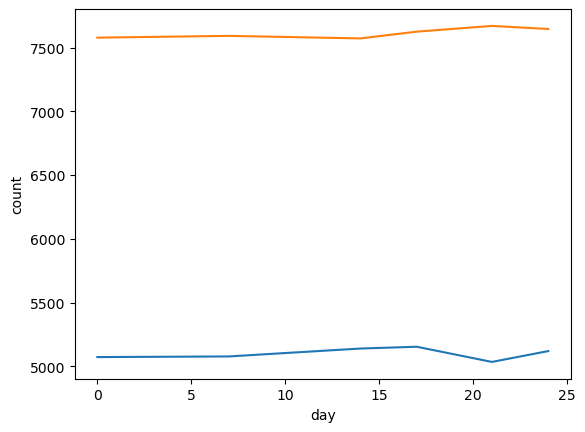

In [69]:
sns.lineplot(data=social_daily_received, x='day', y='count', hue='social', legend=False)

<Axes: xlabel='day'>

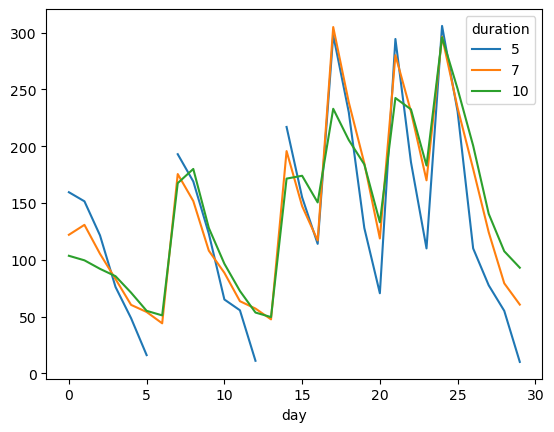

In [70]:
completed_duration = offers_completed[['offer_id', 'reward', 'due_amount', 'day']].merge(offers[['offer_id', 'offer_type', 'duration']], how='inner', on='offer_id')

completed_duration.groupby(['day', 'duration', 'offer_id'])[['reward']].count().reset_index().pivot_table(index='day', columns='duration', values='reward', aggfunc='mean').plot()

In [71]:
offers[offers['offer_type'] == 'discount']['duration'].value_counts()

duration
10    2
7     2
Name: count, dtype: int64

In [72]:
offers[offers['offer_type'] == 'bogo']['duration'].value_counts()

duration
7    2
5    2
Name: count, dtype: int64

<Axes: xlabel='day'>

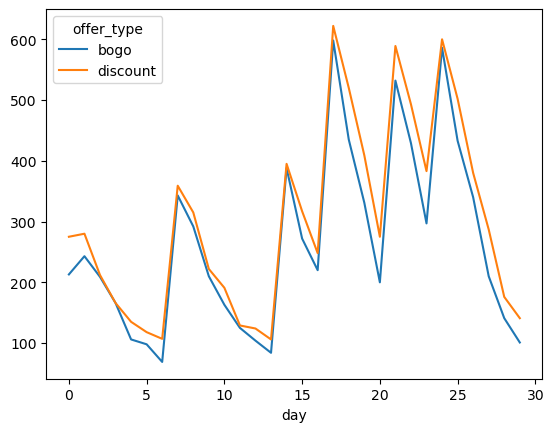

In [73]:
completed_duration7 = completed_duration[completed_duration['duration'] == 7]

completed_duration7.groupby(['day', 'offer_type'], observed=True)[['offer_id']].count().reset_index().pivot(index='day', columns='offer_type', values='offer_id').plot()

In [74]:
offers_completed_offers = offers_completed.merge(offers.drop('reward', axis=1), how='inner', on='offer_id')
offer_type_totals = offers_completed_offers.groupby('offer_type', observed=True)[['difficulty', 'reward', 'discounted_amount', 'due_amount']].sum()

In [75]:
offer_type_totals

,difficulty,reward,discounted_amount,due_amount
offer_type,,,,
bogo,112185,112185.0,0,0
discount,194874,50494.0,0,0


In [76]:
offers_completed_offers.groupby('offer_type', observed=True)[['difficulty', 'reward', 'discounted_amount', 'due_amount']].mean()

,difficulty,reward,discounted_amount,due_amount
offer_type,,,,
bogo,7.237275,7.237275,NaN,NaN
discount,11.021662,2.855834,NaN,NaN


In [77]:
offers_completed_offers.groupby('offer_type', observed=True)[['offer_id']].count()

,offer_id
offer_type,
bogo,15501
discount,17681


In [78]:
standardise_percentage = 15501/17681
standardised_totals = pd.concat([offer_type_totals.loc[['bogo']], offer_type_totals.loc[['discount']] * standardise_percentage])

In [79]:
standardised_totals

,difficulty,reward,discounted_amount,due_amount
offer_type,,,,
bogo,112185.000000,112185.00000,0,0
discount,170846.777558,44268.28125,0.0,0.0


In [80]:
standardised_totals.loc['bogo', 'reward'] - standardised_totals.loc['discount', 'reward']

67916.72

In [81]:
standardised_totals.loc['bogo', 'discounted_amount'] - standardised_totals.loc['discount', 'discounted_amount']

0.0

In [82]:
offer_type_totals.loc['bogo', 'reward'] - offer_type_totals.loc['discount', 'reward']

61691.0

In [83]:
offer_type_totals.loc['bogo', 'discounted_amount'] - offer_type_totals.loc['discount', 'discounted_amount']

0

## Visualisations for Report

In [84]:
# Change default formatting for Matplotlib and Seaborn for this file
plt.rc('axes.spines', right=False, top=False)
plt.rc('font', family='Times New Roman')
plt.rc('axes', labelweight='normal', titleweight='bold')

# Assign Starbucks green to a specific variable
green = '#0b7142'

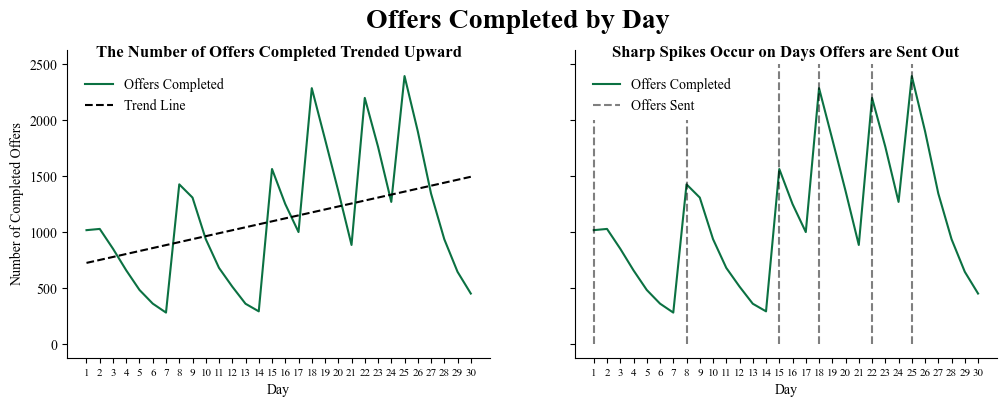

In [85]:
#num_completed_by_day = offers_completed.groupby('day')['offer_id'].count()
#x = num_completed_by_day.index
#y = num_completed_by_day


fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
fig.suptitle("Offers Completed by Day", fontsize=20, fontweight='bold')

sns.lineplot(num_completed_by_day, ax=ax[0], color=green, label='Offers Completed')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax[0].set_title('The Number of Offers Completed Trended Upward', y=0.95)
ax[0].plot(x, p(x), label='Trend Line', color='Black', linestyle='--')
ax[0].set_xticks(num_completed_by_day.index)
ax[0].set_xticklabels(num_completed_by_day.index + 1, fontsize=8)
ax[0].set_ylabel('Number of Completed Offers')
ax[0].set_xlabel('Day')
ax[0].legend(bbox_to_anchor=(0.4, 0.95), frameon=False)


sns.lineplot(num_completed_by_day, ax=ax[1], color=green, label='Offers Completed')
ax[1].set_title('Sharp Spikes Occur on Days Offers are Sent Out', y=0.95)
ax[1].vlines(offers_received_plot.index[2:], 0, 2500, linestyle='--', alpha=0.5, color='black', label='Offers Sent')
ax[1].vlines(offers_received_plot.index[:2], 0, 2000, linestyle='--', alpha=0.5, color='black')
ax[1].set_xticks(num_completed_by_day.index)
ax[1].set_xticklabels(num_completed_by_day.index + 1, fontsize=8)
ax[1].set_xlabel('Day')
ax[1].legend(bbox_to_anchor=(0.4, 0.95), frameon=False)

plt.savefig('ReportImages/OffersCompletedbyDay.png', dpi=1000)

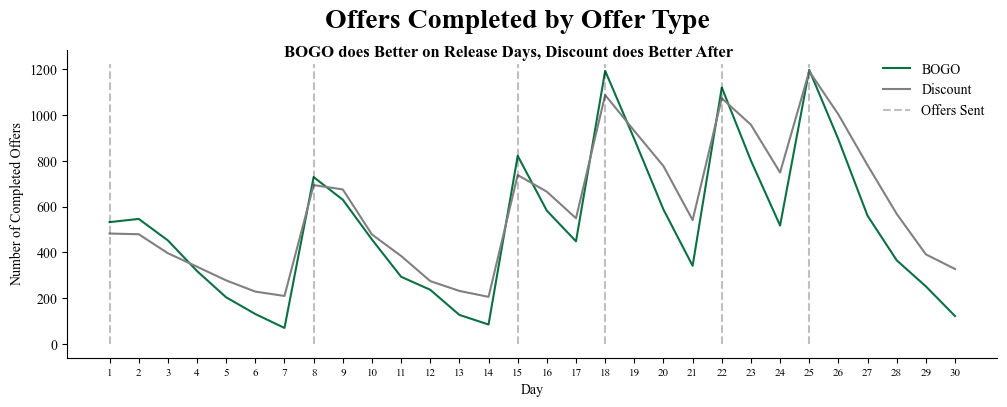

In [86]:
offers_completed_plot = (offers_completed.merge(offers[['offer_id', 'offer_type']], how='inner', on='offer_id')
                                        .pivot_table(index='day', columns='offer_type', values='hour', aggfunc='count', observed=False)
                                        .drop('informational', axis=1))

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Offers Completed by Offer Type", fontsize=20, fontweight='bold')

ax.plot(offers_completed_plot['bogo'], color=green, label='BOGO')
ax.plot(offers_completed_plot['discount'], color='Gray', label='Discount')

ax.set_title('BOGO does Better on Release Days, Discount does Better After', x=0.475, y=0.95)
ax.set_xticks(num_completed_by_day.index)
ax.set_xticklabels(num_completed_by_day.index + 1, fontsize=8)
ax.set_xlabel('Day')
ax.set_ylabel('Number of Completed Offers')
ax.vlines(offers_received_plot.index, 0, 1225, linestyle='--', alpha=0.25, color='black', label='Offers Sent')
ax.legend(['BOGO', 'Discount', 'Offers Sent'], frameon=False)

plt.savefig('ReportImages/OffersCompletedbyOfferType.png', dpi=1000)

In [87]:
funnel_cm = pd.read_sql('SELECT * FROM funnel_cm', con=connection)

In [88]:
social_funnel_count = funnel_cm.merge(offers[['offer_id', 'social']], how='inner', on='offer_id').groupby('social').count()

In [89]:
view_conv_rate_social = (social_funnel_count['num_viewed'] * 100) / social_funnel_count['num_received']

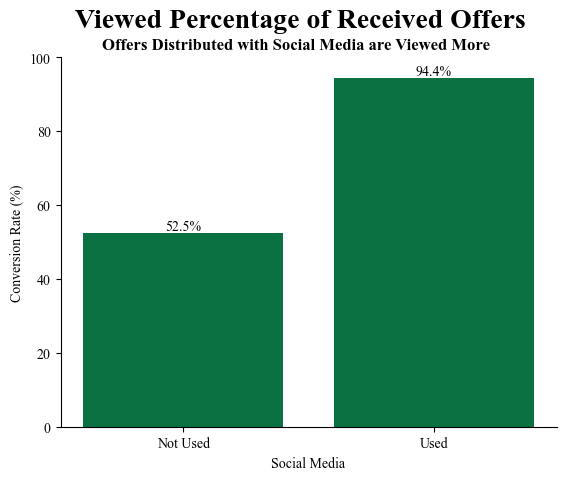

In [90]:
fig, ax = plt.subplots()

fig.suptitle('Viewed Percentage of Received Offers', fontsize=20, fontweight='bold')

bars = ax.bar([0, 1], view_conv_rate_social, color=green)
ax.bar_label(bars, labels=[f'{height:.1f}%' for height in bars.datavalues])

ax.set_title('Offers Distributed with Social Media are Viewed More', x=0.475)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Not Used', 'Used'])
ax.set_xlabel('Social Media')
ax.set_ylim(0, 100)
ax.set_ylabel('Conversion Rate (%)')

plt.savefig('ReportImages/PercentageViewedOffers', dpi=1000)

In [91]:
funnel_cm = funnel_cm.merge(customers, how='inner', on='customer_id')

In [92]:
funnel_gender = funnel_cm.groupby('gender', observed=False)[['num_received', 'num_viewed', 'num_completed']].count().drop('O')

In [93]:
funnel_gender['completed_percentage'] = funnel_gender['num_completed'] / funnel_gender['num_received']

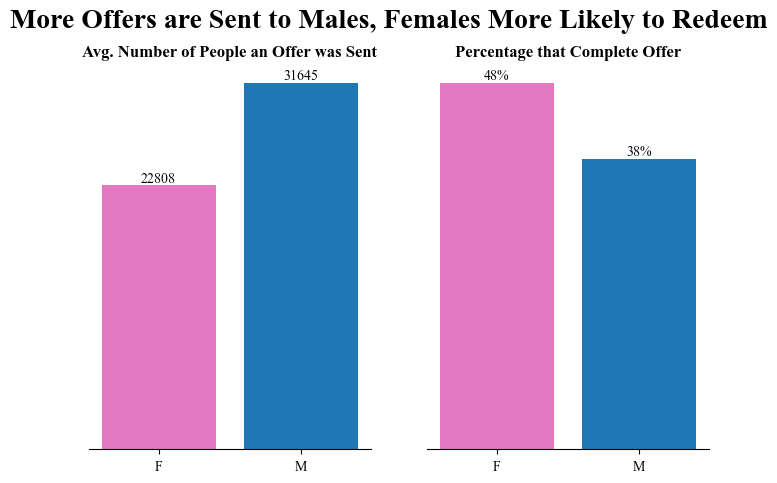

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

fig.suptitle('More Offers are Sent to Males, Females More Likely to Redeem', fontsize=20, fontweight='bold', y=0.99)

bars = ax[0].bar(funnel_gender.index, funnel_gender['num_received'], color=['tab:Pink', 'tab:Blue'])
ax[0].bar_label(bars, labels=[f'{height:.0f}' for height in bars.datavalues])

ax[0].set_title('Avg. Number of People an Offer was Sent')
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(left=False)
ax[0].set_yticklabels([])

bars = ax[1].bar(funnel_gender.index, funnel_gender['completed_percentage'], color=['tab:Pink', 'tab:Blue'])
ax[1].bar_label(bars, labels=[f'{height * 100:.0f}%' for height in bars.datavalues])
ax[1].set_title('Percentage that Complete Offer')
ax[1].spines['left'].set_visible(False)
ax[1].tick_params(left=False)
ax[1].set_yticklabels([])

plt.savefig('ReportImages/GenderOfferEngagement', dpi=1000)
plt.show()

In [95]:
funnel_cm['income_group'] = funnel_cm['income'].round(-4)
funnel_cm['age_group'] = funnel_cm['age'].round(-1)

In [96]:
funnel_cm.dropna()
funnel_cm['young_or_not'] = np.where(funnel_cm['age_group'].isin((20, 30)), '20s and 30s', '40 and Over')

In [97]:
funnel_age_social = (funnel_cm.merge(offers[['offer_id', 'social']], how='inner', on='offer_id')
                              .groupby(['young_or_not', 'social'])[['num_received', 'num_viewed', 'num_completed']]
                              .count()
                              .reset_index())

In [98]:
funnel_age_social['viewed_percentage'] = funnel_age_social['num_viewed'] / funnel_age_social['num_received']

In [99]:
funnel_age_social

,young_or_not,social,num_received,num_viewed,num_completed,viewed_percentage
0,20s and 30s,0,3373,1110,584,0.329084
1,20s and 30s,1,5086,4898,2190,0.963036
2,40 and Over,0,21972,12191,5807,0.554843
3,40 and Over,1,32857,30936,15879,0.941535


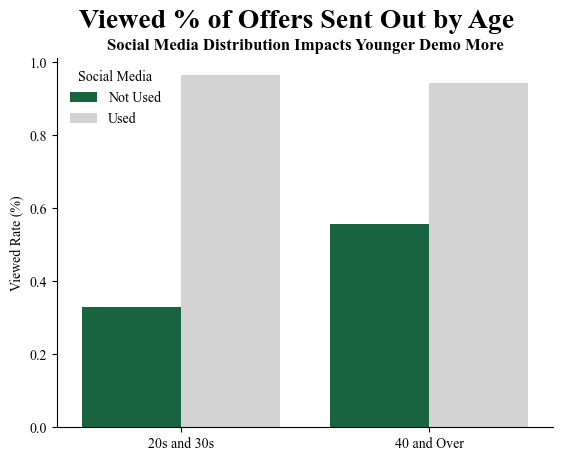

In [100]:
fig, ax = plt.subplots()

fig.suptitle('Viewed % of Offers Sent Out by Age', fontsize=20, fontweight='bold')

bars = sns.barplot(data=funnel_age_social, x='young_or_not', y='viewed_percentage', hue='social', ax=ax, palette={0: green, 1: '#D3D3D3'})

ax.set_title('Social Media Distribution Impacts Younger Demo More')
ax.set_ylabel('Viewed Rate (%)')
ax.set_xlabel('')


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[0], handles[1]], labels=['Not Used', 'Used'], title='Social Media', frameon=False)

plt.savefig('ReportImages/ViewedPercentageAgeSocialMedia', dpi=1000)